In [1]:
# Main imports
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import (Lasso, LassoCV, LogisticRegression,
                                  LogisticRegressionCV, LinearRegression,
                                  MultiTaskElasticNet, MultiTaskElasticNetCV)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import pandas as pd

from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
import osmnx as ox
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import rasterio
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
ox.config(use_cache=True, log_console=False)

In [3]:
src = rasterio.open('LongNTL_2020.tif')

In [16]:
data = pd.read_csv("./LightPollution/Shanghai_final.csv")
data = gpd.GeoDataFrame(
    data.loc[:, [c for c in data.columns if c != "geometry"]],
    geometry = gpd.GeoSeries.from_wkt(data["geometry"]),
    crs="EPSG:4326")
data.drop(["Unnamed: 0"], axis = 1, inplace = True)
data

,ID,name,name:en,landuse,addr:province,addr:city,addr:district,description,address,type,...,grass_mean_distance,grass_mean_NTL,industrial_mean_distance,industrial_mean_NTL,residential_mean_distance,residential_mean_NTL,retail_mean_distance,retail_mean_NTL,Over_illumination,geometry
0,0,宜浩·佳园北区,NaN,residential,NaN,NaN,NaN,NaN,NaN,NaN,...,2553.979103,35.928333,3601.600811,7.845,NaN,NaN,NaN,NaN,391.140000,"POLYGON ((121.90457 30.90741, 121.90455 30.905..."
1,1,宜浩·佳园南区,NaN,residential,NaN,NaN,NaN,NaN,NaN,NaN,...,2341.801064,35.928333,NaN,NaN,NaN,NaN,NaN,NaN,408.790000,"POLYGON ((121.90285 30.90299, 121.90292 30.900..."
2,2,宜浩·欧景,NaN,residential,上海市,浦东新区,南汇新城镇,限价房住宅小区,NaN,NaN,...,2842.622379,36.995000,2862.263448,7.845,NaN,NaN,NaN,NaN,270.050002,"POLYGON ((121.90627 30.91558, 121.90976 30.918..."
3,3,东辰源著,NaN,residential,上海市,浦东新区,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((121.91958 30.91962, 121.92286 30.922..."
4,4,海上风华,NaN,residential,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.245001,"POLYGON ((121.91642 30.92391, 121.91789 30.922..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8791,8791,金色家园,NaN,residential,NaN,NaN,NaN,NaN,NaN,multipolygon,...,NaN,NaN,NaN,NaN,1207.430420,11.737187,354.790559,13.485001,201.280000,"MULTIPOLYGON (((118.82174 31.56216, 118.82205 ..."
8792,8792,多蓝水岸,NaN,residential,NaN,NaN,NaN,NaN,NaN,multipolygon,...,NaN,NaN,2412.037793,2.740,1458.407578,11.723611,2088.102149,13.485001,227.250000,"MULTIPOLYGON (((118.83326 31.56708, 118.83316 ..."
8793,8793,紫金城,NaN,residential,NaN,NaN,NaN,NaN,NaN,multipolygon,...,NaN,NaN,2807.382592,2.740,1309.315400,11.723611,1691.610760,13.485001,227.250000,"MULTIPOLYGON (((118.83212 31.56755, 118.83233 ..."
8794,8794,禄港街区,NaN,residential,NaN,NaN,NaN,NaN,NaN,multipolygon,...,NaN,NaN,2354.315749,7.525,1166.016971,18.272187,NaN,NaN,400.844997,"MULTIPOLYGON (((118.84425 31.78409, 118.84315 ..."


In [17]:
features = ['brownfield', 'brownfield_mean_distance', 'brownfield_mean_NTL',
            'commercial', 'commercial_mean_distance', 'commercial_mean_NTL',
            'construction', 'construction_mean_distance', 'construction_mean_NTL',
            'farmland', 'farmland_mean_distance', 'farmland_mean_NTL',
            'forest', 'forest_mean_distance', 'forest_mean_NTL', 
            'grass',  'grass_mean_distance', 'grass_mean_NTL',
            'industrial', 'industrial_mean_distance', 'industrial_mean_NTL',
            'residential', 'residential_mean_distance', 'residential_mean_NTL', 
            'retail', 'retail_mean_distance', 'retail_mean_NTL']
len(features)

27

In [18]:
data.drop(data[data["Trespass"] > 10].index, axis = 0, inplace = True)
data.shape

(8721, 45)

In [19]:
mean_val = data.mean()
data = data.fillna(mean_val)

In [20]:
data["Over_illumination"] = (data["Over_illumination"] - data["Over_illumination"].min()) / (data["Over_illumination"].max() - data["Over_illumination"].min())
data["Trespass"] = (data["Trespass"] - data["Trespass"].min()) / (data["Trespass"].max() - data["Trespass"].min())
data["Clutter"] = (data["Clutter"] - data["Clutter"].min()) / (data["Clutter"].max() - data["Clutter"].min())

In [21]:
data[["Over_illumination", "Trespass", "Clutter"]]

,Over_illumination,Trespass,Clutter
3,0.171093,0.159335,0.264823
5,0.096411,0.101713,0.221223
6,0.101774,0.117950,0.249845
7,0.099107,0.114882,0.239913
8,0.102520,0.116960,0.243475
...,...,...,...
8791,0.005163,0.007548,0.170314
8792,0.005830,0.005468,0.076968
8793,0.005830,0.006375,0.093361
8794,0.010283,0.014288,0.227644


In [22]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['residential', 'residential_mean_distance', 'residential_mean_NTL']]].values)
T = scaler.fit_transform(data[['residential', 'residential_mean_distance', 'residential_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

Summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
Summary.reset_index(inplace=True)

Summary["Treatment"] = "residential"

Summary

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.422,0.003,127.004,0.0,0.416,0.427,residential
1,0,Y1,0.380,0.005,84.297,0.0,0.373,0.388,residential
2,0,Y2,0.399,0.009,46.307,0.0,0.385,0.413,residential


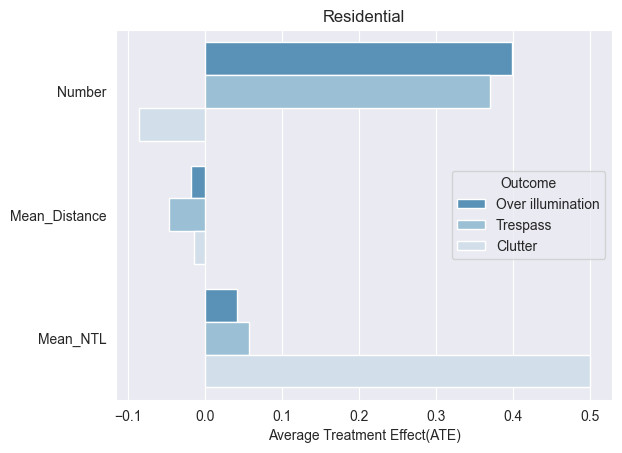

In [24]:
residential_effect = pd.DataFrame(est.const_marginal_ate().T, columns = ["Over illumination", "Trespass", "Clutter"])
residential_effect["Treatment"] = ["Number", "Mean_Distance", "Mean_NTL"]
residential_effect = pd.melt(residential_effect, id_vars=["Treatment"], var_name = "Outcome")
residential_effect

sns.set_style("darkgrid")

flatui = ["#4995C6", "#92C2DD", "#CEDFEF"]
sns.set_palette(flatui)

g = sns.barplot(
    data = residential_effect,
    y="Treatment", x="value", hue="Outcome", palette = sns.color_palette(), alpha = 1,
    orient='h'
)
g.set(ylabel='', xlabel = "Average Treatment Effect(ATE)", title="Residential")
plt.legend(title = "Outcome", loc="center right")
plt.savefig("residential5.svg", bbox_inches = "tight")

In [25]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['commercial', 'commercial_mean_distance', 'commercial_mean_NTL']]].values)
T = scaler.fit_transform(data[['commercial', 'commercial_mean_distance', 'commercial_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary.reset_index(inplace=True)

summary["Treatment"] = "commercial"
summary
Summary = pd.concat([Summary, summary], axis = 0)

Summary

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.422,0.003,127.004,0.000,0.416,0.427,residential
1,0,Y1,0.380,0.005,84.297,0.000,0.373,0.388,residential
2,0,Y2,0.399,0.009,46.307,0.000,0.385,0.413,residential
0,0,Y0,0.285,0.005,52.094,0.000,0.276,0.294,commercial
1,0,Y1,0.267,0.007,37.584,0.000,0.256,0.279,commercial
2,0,Y2,-0.007,0.014,-0.497,0.619,-0.031,0.016,commercial


In [26]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['retail', 'retail_mean_distance', 'retail_mean_NTL']]].values)
T = scaler.fit_transform(data[['retail', 'retail_mean_distance', 'retail_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3),
                model_t = MultiTaskElasticNetCV(cv = 3),
                linear_first_stages = True)

est.fit(Y, T, W = W)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "retail"
Summary = pd.concat([Summary, summary], axis = 0)
Summary

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.422,0.003,127.004,0.000,0.416,0.427,residential
1,0,Y1,0.380,0.005,84.297,0.000,0.373,0.388,residential
2,0,Y2,0.399,0.009,46.307,0.000,0.385,0.413,residential
0,0,Y0,0.285,0.005,52.094,0.000,0.276,0.294,commercial
1,0,Y1,0.267,0.007,37.584,0.000,0.256,0.279,commercial
2,0,Y2,-0.007,0.014,-0.497,0.619,-0.031,0.016,commercial
0,0,Y0,0.187,0.006,32.466,0.000,0.178,0.197,retail
1,0,Y1,0.147,0.010,14.261,0.000,0.130,0.164,retail
2,0,Y2,-0.006,0.012,-0.480,0.631,-0.026,0.014,retail


In [27]:
scaler = MinMaxScaler()

W = scaler.fit_transform(data[[c for c in features if c not in ['brownfield', 'brownfield_mean_distance', 'brownfield_mean_NTL']]].values)
T = scaler.fit_transform(data[['brownfield', 'brownfield_mean_distance', 'brownfield_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

Summary2 = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
Summary2.reset_index(inplace=True)

Summary2["Treatment"] = "brownfield"
# Summary = pd.concat([Summary, summary], axis = 0)

Summary2

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.083,0.010,8.636,0.000,0.067,0.099,brownfield
1,0,Y1,0.085,0.014,5.934,0.000,0.061,0.108,brownfield
2,0,Y2,0.013,0.021,0.652,0.514,-0.020,0.047,brownfield


In [28]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['construction', 'construction_mean_distance', 'construction_mean_NTL',]]].values)
T = scaler.fit_transform(data[['construction', 'construction_mean_distance', 'construction_mean_NTL',]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)
est.effect_inference().population_summary(alpha = 0.1, value = 0, decimals = 3, tol = 0.001)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "construction"
Summary2 = pd.concat([Summary2, summary], axis = 0)
Summary2

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.083,0.010,8.636,0.000,0.067,0.099,brownfield
1,0,Y1,0.085,0.014,5.934,0.000,0.061,0.108,brownfield
2,0,Y2,0.013,0.021,0.652,0.514,-0.020,0.047,brownfield
0,0,Y0,0.065,0.005,13.544,0.000,0.057,0.073,construction
1,0,Y1,0.043,0.006,7.175,0.000,0.033,0.053,construction
2,0,Y2,-0.042,0.013,-3.217,0.001,-0.063,-0.020,construction


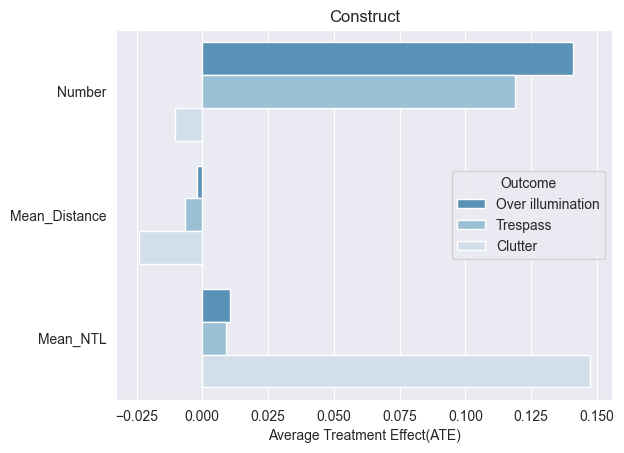

In [16]:
construct_effect = pd.DataFrame(est.const_marginal_ate().T, columns = ["Over illumination", "Trespass", "Clutter"])
construct_effect["Treatment"] = ["Number", "Mean_Distance", "Mean_NTL"]
construct_effect = pd.melt(construct_effect, id_vars=["Treatment"], var_name = "Outcome")
construct_effect

sns.set_style("darkgrid")

flatui = ["#4995C6", "#92C2DD", "#CEDFEF"]
sns.set_palette(flatui)

g = sns.barplot(
    data = construct_effect,
    y="Treatment", x="value", hue="Outcome", palette = sns.color_palette(), alpha = 1,
    orient='h'
)

g.set(ylabel='', xlabel = "Average Treatment Effect(ATE)", title="Construct")
plt.legend(title = "Outcome", loc="center right")
plt.savefig("construct3.svg", bbox_inches = "tight")

In [29]:
scaler = MinMaxScaler()

W = scaler.fit_transform(data[[c for c in features if c not in ['industrial', 'industrial_mean_distance', 'industrial_mean_NTL']]].values)
T = scaler.fit_transform(data[['industrial', 'industrial_mean_distance', 'industrial_mean_NTL',]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "industrial"
Summary2 = pd.concat([Summary2, summary], axis = 0)
Summary2

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.083,0.010,8.636,0.000,0.067,0.099,brownfield
1,0,Y1,0.085,0.014,5.934,0.000,0.061,0.108,brownfield
2,0,Y2,0.013,0.021,0.652,0.514,-0.020,0.047,brownfield
0,0,Y0,0.065,0.005,13.544,0.000,0.057,0.073,construction
1,0,Y1,0.043,0.006,7.175,0.000,0.033,0.053,construction
2,0,Y2,-0.042,0.013,-3.217,0.001,-0.063,-0.020,construction
0,0,Y0,0.160,0.005,31.862,0.000,0.152,0.168,industrial
1,0,Y1,0.125,0.007,17.347,0.000,0.113,0.137,industrial
2,0,Y2,0.038,0.014,2.677,0.007,0.015,0.061,industrial


In [30]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['grass', 'grass_mean_distance', 'grass_mean_NTL']]].values)
T = scaler.fit_transform(data[['grass', 'grass_mean_distance', 'grass_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)
est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

Summary3 = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
Summary3.reset_index(inplace=True)

Summary3["Treatment"] = "grass"
Summary3

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.573,0.009,64.444,0.0,0.558,0.587,grass
1,0,Y1,0.431,0.012,36.037,0.0,0.412,0.451,grass
2,0,Y2,-0.097,0.015,-6.281,0.0,-0.122,-0.071,grass


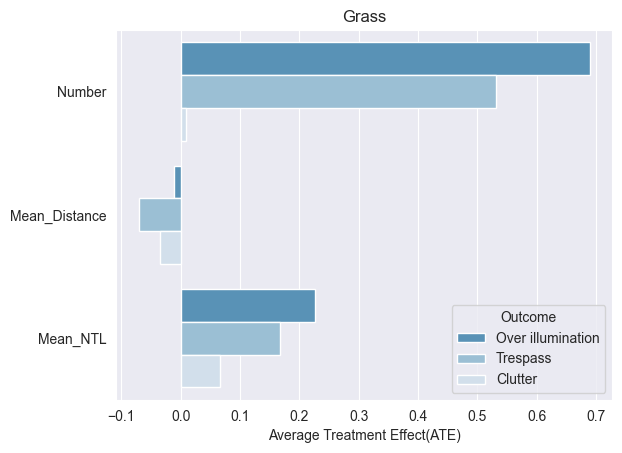

In [19]:
grass_effect = pd.DataFrame(est.const_marginal_ate().T, columns = ["Over illumination", "Trespass", "Clutter"])
grass_effect["Treatment"] = ["Number", "Mean_Distance", "Mean_NTL"]
grass_effect = pd.melt(grass_effect, id_vars=["Treatment"], var_name = "Outcome")
grass_effect

sns.set_style("darkgrid")

flatui = ["#4995C6", "#92C2DD", "#CEDFEF"]
sns.set_palette(flatui)

g = sns.barplot(
    data = grass_effect,
    y = "Treatment", x = "value", hue = "Outcome", palette = sns.color_palette(), alpha = 1,
    orient='h'
)

g.set(ylabel='', xlabel = "Average Treatment Effect(ATE)", title = "Grass")
plt.savefig("grass5.svg", bbox_inches = "tight")

In [31]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['farmland', 'farmland_mean_distance', 'farmland_mean_NTL']]].values)
T = scaler.fit_transform(data[['farmland', 'farmland_mean_distance', 'farmland_mean_NTL',]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)
est.effect_inference().population_summary(alpha = 0.1, value = 0, decimals = 3, tol = 0.001)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "farmland"
Summary3 = pd.concat([Summary3, summary], axis = 0)
Summary3

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.573,0.009,64.444,0.000,0.558,0.587,grass
1,0,Y1,0.431,0.012,36.037,0.000,0.412,0.451,grass
2,0,Y2,-0.097,0.015,-6.281,0.000,-0.122,-0.071,grass
0,0,Y0,0.007,0.005,1.341,0.180,-0.001,0.015,farmland
1,0,Y1,0.017,0.008,2.109,0.035,0.004,0.030,farmland
2,0,Y2,0.026,0.019,1.397,0.162,-0.005,0.056,farmland


In [32]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['forest', 'forest_mean_distance', 'forest_mean_NTL']]].values)
T = scaler.fit_transform(data[['forest', 'forest_mean_distance', 'forest_mean_NTL', ]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, tol = 1),
                model_t = MultiTaskElasticNetCV(cv = 3),
                linear_first_stages = True)

est.fit(Y, T, W = W)
est.effect_inference().population_summary(alpha = 0.1, value = 0, decimals = 3, tol = 0.001)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "forest"
Summary3 = pd.concat([Summary3, summary], axis = 0)
Summary3

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.573,0.009,64.444,0.000,0.558,0.587,grass
1,0,Y1,0.431,0.012,36.037,0.000,0.412,0.451,grass
2,0,Y2,-0.097,0.015,-6.281,0.000,-0.122,-0.071,grass
0,0,Y0,0.007,0.005,1.341,0.180,-0.001,0.015,farmland
1,0,Y1,0.017,0.008,2.109,0.035,0.004,0.030,farmland
2,0,Y2,0.026,0.019,1.397,0.162,-0.005,0.056,farmland
0,0,Y0,0.298,0.017,17.805,0.000,0.271,0.326,forest
1,0,Y1,0.247,0.019,13.283,0.000,0.217,0.278,forest
2,0,Y2,0.005,0.021,0.242,0.809,-0.029,0.039,forest


In [33]:
Summary.loc[Summary["Y"]=="Y0", "Y"] = "Over Illumination"
Summary.loc[Summary["Y"]=="Y1", "Y"] = "Trespass"
Summary.loc[Summary["Y"]=="Y2", "Y"] = "Clutter"

Summary.rename(columns={"Y": "Outcome"}, inplace = True)

In [34]:
Summary2.loc[Summary2["Y"]=="Y0", "Y"] = "Over Illumination"
Summary2.loc[Summary2["Y"]=="Y1", "Y"] = "Trespass"
Summary2.loc[Summary2["Y"]=="Y2", "Y"] = "Clutter"

Summary2.rename(columns={"Y": "Outcome"}, inplace = True)

In [35]:
Summary3.loc[Summary3["Y"]=="Y0", "Y"] = "Over Illumination"
Summary3.loc[Summary3["Y"]=="Y1", "Y"] = "Trespass"
Summary3.loc[Summary3["Y"]=="Y2", "Y"] = "Clutter"

Summary3.rename(columns = {"Y": "Outcome"}, inplace = True)

In [36]:
Summarys = [Summary, Summary2, Summary3]

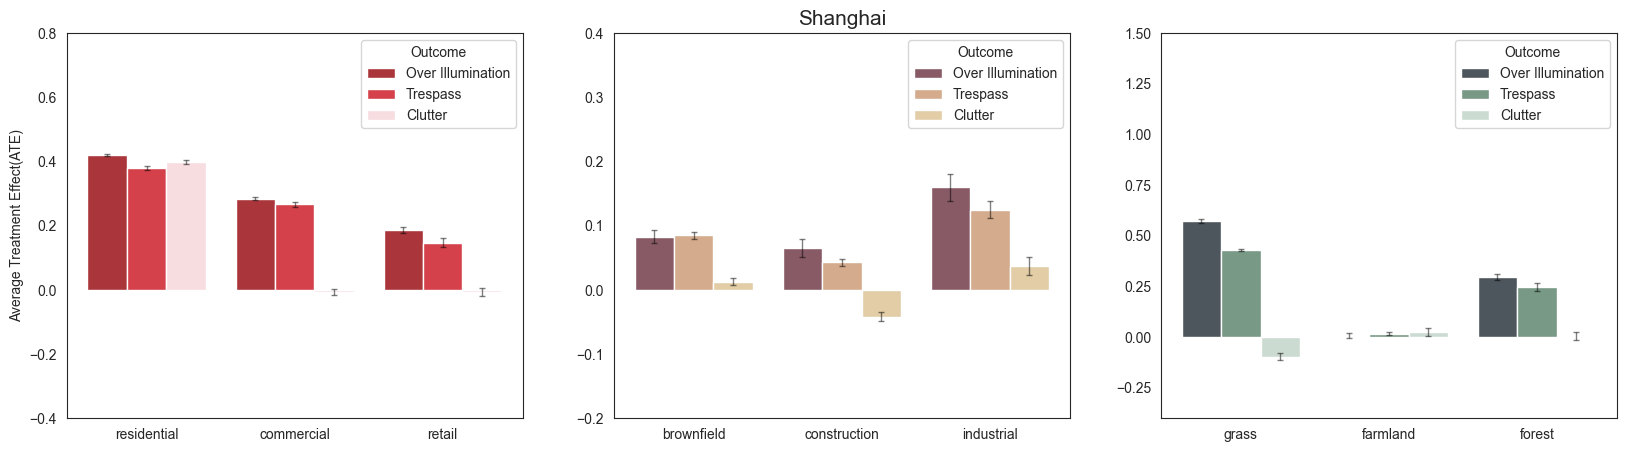

In [41]:
import pandas as pd
import seaborn as sns


# plt.figure(figsize = (20, 5))
sns.set_style("white")

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

flatui = ["#BD2329", "#EC2835", "#FCD7DD"]
sns.set_palette(flatui)

sns.barplot(
    data = Summary,
    x = "Treatment", y = "point_estimate", hue = "Outcome", palette = sns.color_palette(), alpha = 1, ax = axes[0]
)

flatui = ["#8f5362", "#e0a981", "#ecd09c"]
sns.set_palette(flatui)

axes[1] = sns.barplot(
    data = Summary2,
    x = "Treatment", y = "point_estimate", hue = "Outcome", palette = sns.color_palette(), alpha = 1, ax = axes[1]
)

# flatui = ["#79b4a0", "#a3c8a4", "#d4daa1"]
# sns.set_palette(flatui)

flatui = ["#4A565F", "#719F85", "#CADDD1"]
sns.set_palette(flatui)

axes[2] = sns.barplot(
    data = Summary3,
    x = "Treatment", y = "point_estimate", hue = "Outcome", palette = sns.color_palette(), alpha = 1, ax = axes[2]
)

for index in range(3):
    x = Summarys[index]["Treatment"]
    y = Summarys[index]["point_estimate"]
    yerr = Summarys[index]["stderr"]
    
    bars = [c for c in axes[index].get_children() if isinstance(c, matplotlib.patches.Rectangle)]
    bars = bars[:-1]
    
    for i, bar in enumerate(bars):
            height = bar.get_height()
            x_pos = bar.get_x() + bar.get_width() / 2
            axes[index].errorbar(x = x_pos, y = height, yerr = yerr.iloc[i], fmt = 'none', capsize = 2, color = 'black', elinewidth = 1, alpha = 0.5)

# plt.savefig("ATE2.svg", bbox_inches = "tight")
axes[0].set(xlabel = '', ylabel = "Average Treatment Effect(ATE)")

# axes[0].legend().set_visible(False)
# axes[1].legend().set_visible(False)

axes[1].set(xlabel = '', ylabel = "")
axes[0].set_ylim([-0.4, 0.8])
axes[1].set_ylim([-0.2, 0.4])
axes[1].set_title("Shanghai", fontsize = 15)
axes[2].set_ylim([-0.4, 1.5])
axes[2].set(xlabel = '', ylabel = "")

plt.savefig("ATE_SH.svg", bbox_inches = "tight")

In [35]:
data[["residential", "commercial", "retail", "brownfield", "construction", "industrial", "grass", "farmland", "forest", "Over_illumination", "Trespass", "Clutter"]].corr()

,residential,commercial,retail,brownfield,construction,industrial,grass,farmland,forest,Over_illumination,Trespass,Clutter
residential,1.000000,0.487346,0.207647,0.199052,-0.094548,0.133141,0.197714,-0.019465,-0.112484,0.449982,0.403501,0.203771
commercial,0.487346,1.000000,0.596199,0.601294,0.443337,0.199149,0.288679,0.021711,-0.046175,0.717630,0.375849,0.181972
retail,0.207647,0.596199,1.000000,0.567564,0.472152,0.115931,0.182829,-0.070967,0.070740,0.627858,0.187588,0.090576
brownfield,0.199052,0.601294,0.567564,1.000000,0.603769,0.213317,0.194097,-0.019330,0.010999,0.546816,0.118519,0.085119
construction,-0.094548,0.443337,0.472152,0.603769,1.000000,-0.047921,0.199320,-0.074886,0.115983,0.421208,-0.002375,-0.019915
industrial,0.133141,0.199149,0.115931,0.213317,-0.047921,1.000000,0.063281,0.100144,-0.112862,0.250663,-0.061590,-0.090134
grass,0.197714,0.288679,0.182829,0.194097,0.199320,0.063281,1.000000,0.097692,0.043349,0.685291,0.217337,0.090322
farmland,-0.019465,0.021711,-0.070967,-0.019330,-0.074886,0.100144,0.097692,1.000000,-0.064941,-0.019765,-0.022857,0.009071
forest,-0.112484,-0.046175,0.070740,0.010999,0.115983,-0.112862,0.043349,-0.064941,1.000000,0.030826,-0.080207,-0.100032
Over_illumination,0.449982,0.717630,0.627858,0.546816,0.421208,0.250663,0.685291,-0.019765,0.030826,1.000000,0.297270,0.105989
